In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [13]:
df = pd.read_csv('../../data/togo-dapaong_qc.csv')
assert not df.empty, "Data import failed - DataFrame is empty!"

In [4]:
# First 5 rows
print(df.head())

          Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0  2021-10-25 00:01 -1.3  0.0  0.0   0.0   0.0  24.8  94.5  0.9     1.1   
1  2021-10-25 00:02 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.1     1.6   
2  2021-10-25 00:03 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.2     1.4   
3  2021-10-25 00:04 -1.2  0.0  0.0   0.0   0.0  24.8  94.3  1.2     1.6   
4  2021-10-25 00:05 -1.2  0.0  0.0   0.0   0.0  24.8  94.0  1.3     1.6   

   WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  TModA  TModB  \
0      0.4  227.6      1.1  977         0            0.0   24.7   24.4   
1      0.4  229.3      0.7  977         0            0.0   24.7   24.4   
2      0.3  228.5      2.9  977         0            0.0   24.7   24.4   
3      0.3  229.1      4.6  977         0            0.0   24.7   24.4   
4      0.4  227.5      1.6  977         0            0.0   24.7   24.4   

   Comments  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  


### Summary Statistics & Missing-Value Report


In [14]:
print("The description of the numeric columns:")
summary_stats = df.describe()
print(summary_stats)
# Overview of categorical columns
print("---------------------------------")
print("The description of the categorical columns:")
print(df.describe(include=['object']))
# Overview of all columns
print("---------------------------------")
print("The description of all columns:")
print(df.describe(include='all'))
# Overview of the dataset
print("----------------------------------")
print("An overview of the dataset: the last 5 rows")
print(df.tail())
# Overview of the dataset
print("----------------------------------")
print("An overview of the dataset: a random sample of 5 rows")
print(df.sample(5))
# Overview of the dataset
print("----------------------------------")
print("An overview of the dataset: the shape of the dataset")
print(df.info())

# Total missing values per column
missing_values = df.isna().sum()
print("Missing values per column:")
print(missing_values)

# Flag columns with >5% nulls
total_rows = len(df)
high_null_cols = missing_values[missing_values > 0.05 * total_rows]
print("\nColumns with >5% nulls:")
print(high_null_cols)

The description of the numeric columns:
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      230.555040     151.258469     116.444352     226.144375   
std       322.532347     250.956962     156.520714     317.346938   
min       -12.700000       0.000000       0.000000       0.000000   
25%        -2.200000       0.000000       0.000000       0.000000   
50%         2.100000       0.000000       2.500000       4.400000   
75%       442.400000     246.400000     215.700000     422.525000   
max      1424.000000    1004.500000     805.700000    1380.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      219.568588      27.751788      55.013160       2.368093   
std       307.932510       4.758023      28.778732       1.462668   
min         0.000000      14.900000       3.300000       0.000

### Outlier Detection & Basic Cleaning


In [15]:
# Columns to check for outliers
sensor_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Calculate Z-scores and flag outliers
for col in sensor_cols:
    if col in df.columns:
        df[f'{col}_zscore'] = np.abs(stats.zscore(df[col]))
        df[f'{col}_outlier'] = df[f'{col}_zscore'] > 3

# Show outlier counts
print("Outlier counts per column:")
print(df[[f'{col}_outlier' for col in sensor_cols if f'{col}_outlier' in df]].sum())

Outlier counts per column:
GHI_outlier        305
DNI_outlier       1062
DHI_outlier       3415
ModA_outlier       137
ModB_outlier       206
WS_outlier        3510
WSgust_outlier    3915
dtype: int64


Handle Missing values

In [16]:
for col in sensor_cols:
    if col in df.columns:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

# Drop rows with missing timestamps
df = df.dropna(subset=['Timestamp'])

print("\nMissing values after cleaning:")
print(df[sensor_cols].isna().sum())


Missing values after cleaning:
GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64


Remove or Correct Outliers

In [17]:
# Option 1: Replace outliers with median
for col in sensor_cols:
    if col in df.columns:
        median_val = df[col].median()
        df.loc[df[f'{col}_outlier'], col] = median_val

# Option 2: Drop outlier rows (uncomment to use)
# df = df[~df[[f'{col}_outlier' for col in sensor_cols]].any(axis=1)]

# Drop Z-score columns (no longer needed)
df = df.drop(columns=[f'{col}_zscore' for col in sensor_cols if f'{col}_zscore' in df])
df = df.drop(columns=[f'{col}_outlier' for col in sensor_cols if f'{col}_outlier' in df])

Export Cleaned Data

In [18]:
import os

# Create data/ directory if it doesn't exist
os.makedirs('../../data/', exist_ok=True)

# Export (for togo)
output_path = '../../data/togo-dapaong_qc_clean.csv'
df.to_csv(output_path, index=False)

print(f"\nCleaned data saved to {output_path}")


Cleaned data saved to ../../data/togo-dapaong_qc_clean.csv


### Time Series Analysis

C:\Users\hp\AppData\Local\Temp\ipykernel_8360\1325059505.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df[['GHI', 'DNI', 'DHI', 'Tamb']].resample('H').mean()


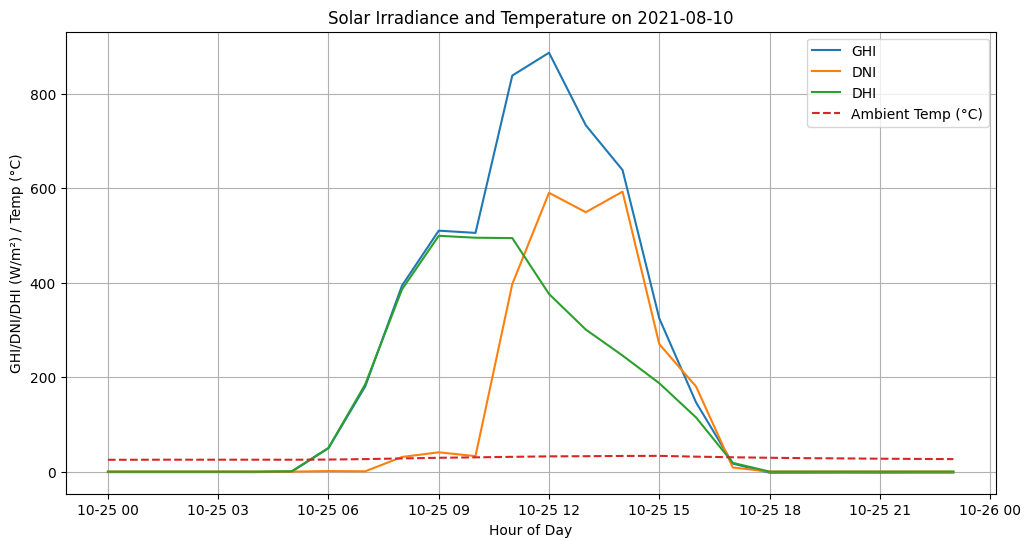

In [19]:
# Convert 'Timestamp' to datetime and set as index
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')

# Resample to hourly averages (reduce noise for clearer trends)
df_hourly = df[['GHI', 'DNI', 'DHI', 'Tamb']].resample('H').mean()

# Extract a single day (e.g., 2021-08-10)
single_day = df_hourly.loc['2021-10-25']

plt.figure(figsize=(12, 6))
plt.plot(single_day.index, single_day['GHI'], label='GHI')
plt.plot(single_day.index, single_day['DNI'], label='DNI')
plt.plot(single_day.index, single_day['DHI'], label='DHI')
plt.plot(single_day.index, single_day['Tamb'], label='Ambient Temp (°C)', linestyle='--')

plt.title('Solar Irradiance and Temperature on 2021-08-10')
plt.xlabel('Hour of Day')
plt.ylabel('GHI/DNI/DHI (W/m²) / Temp (°C)')
plt.legend()
plt.grid()
plt.show()

Anomaly Detection (Rolling Averages)

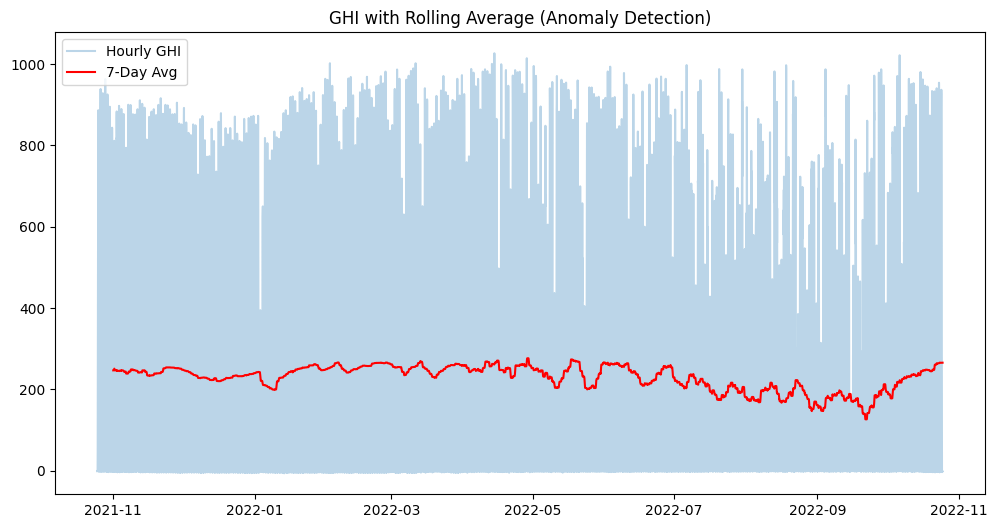

In [20]:
# 7-day rolling average for GHI
df_hourly['GHI_7day_avg'] = df_hourly['GHI'].rolling(window=7*24).mean()

# Plot anomalies (e.g., dips due to dust storms)
plt.figure(figsize=(12, 6))
plt.plot(df_hourly.index, df_hourly['GHI'], label='Hourly GHI', alpha=0.3)
plt.plot(df_hourly.index, df_hourly['GHI_7day_avg'], label='7-Day Avg', color='red')
plt.title('GHI with Rolling Average (Anomaly Detection)')
plt.legend()
plt.show()

Cleaning Impact Analysis

<Figure size 1200x600 with 0 Axes>

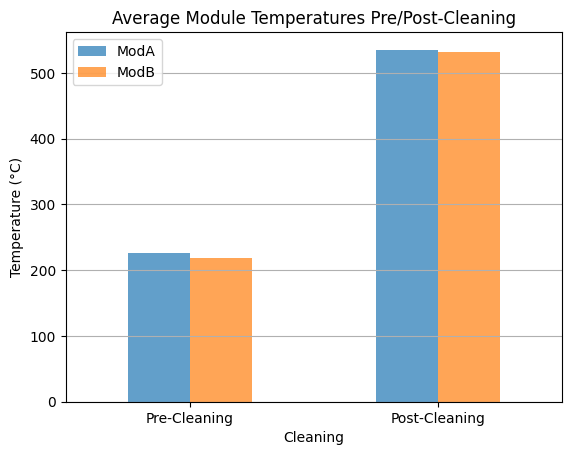

In [21]:
# Group by Cleaning flag and compare module temperatures
plt.figure(figsize=(12, 6))
df.groupby('Cleaning')[['ModA', 'ModB']].mean().plot(kind='bar', alpha=0.7)
plt.title('Average Module Temperatures Pre/Post-Cleaning')
plt.ylabel('Temperature (°C)')
plt.xticks([0,1], ['Pre-Cleaning', 'Post-Cleaning'], rotation=0)
plt.grid(axis='y')
plt.show()

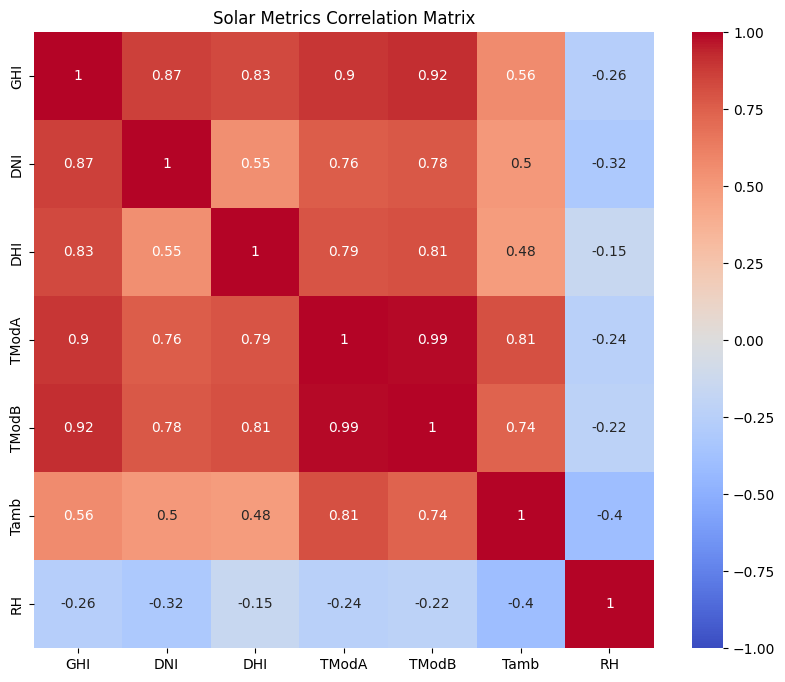

In [22]:
corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'Tamb', 'RH']
plt.figure(figsize=(10, 8))
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Solar Metrics Correlation Matrix')
plt.show()

Scatter Plots

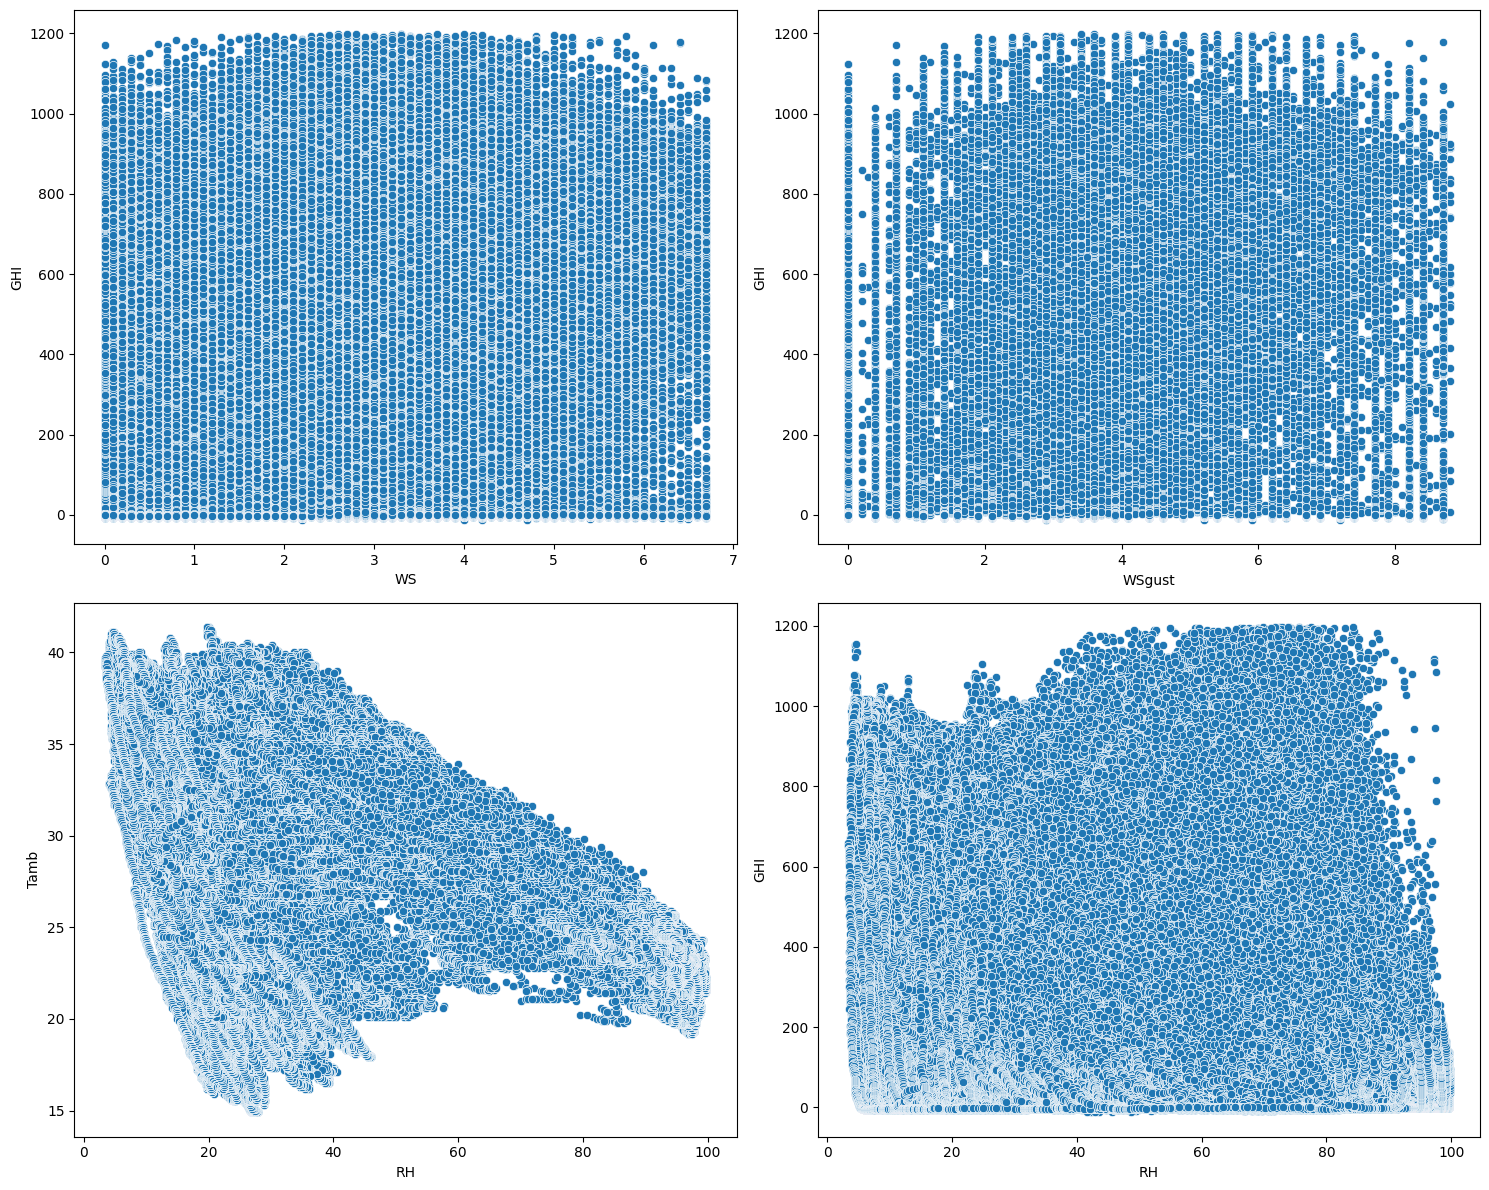

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

# Wind vs Irradiance
sns.scatterplot(data=df, x='WS', y='GHI', ax=ax[0,0])
sns.scatterplot(data=df, x='WSgust', y='GHI', ax=ax[0,1])

# Humidity Relationships
sns.scatterplot(data=df, x='RH', y='Tamb', ax=ax[1,0])
sns.scatterplot(data=df, x='RH', y='GHI', ax=ax[1,1])

plt.tight_layout()
plt.show()

Wind Analysis

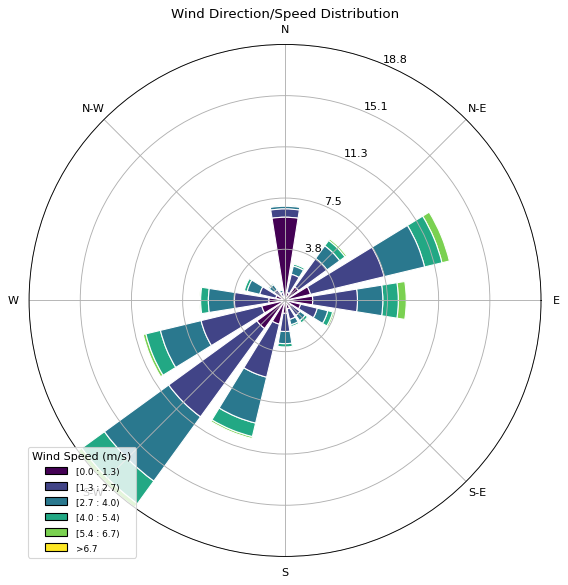

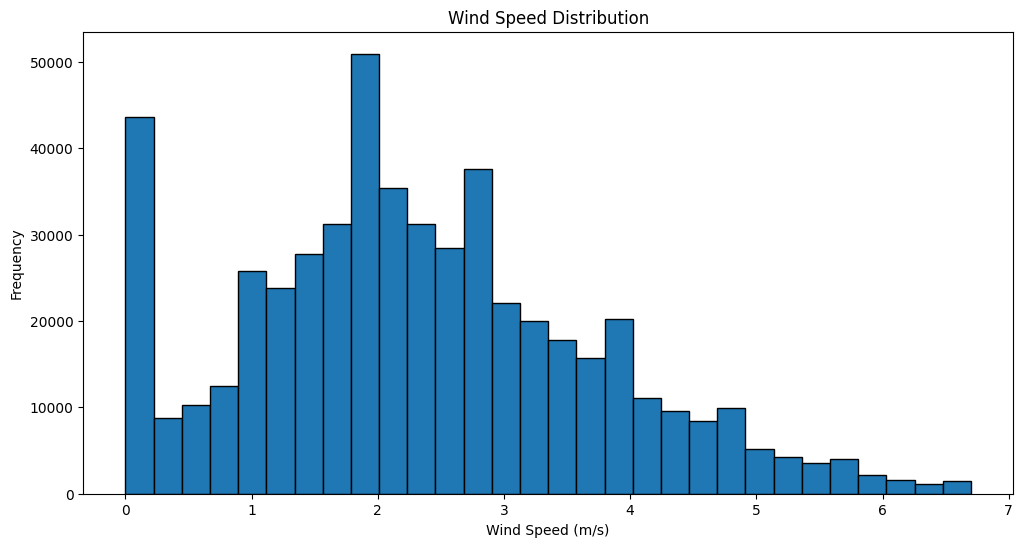

In [24]:
from windrose import WindroseAxes

# Wind Rose (requires windrose package: pip install windrose)
ax = WindroseAxes.from_ax()
ax.bar(df['WD'], df['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend(title='Wind Speed (m/s)')
plt.title('Wind Direction/Speed Distribution')
plt.show()

# Wind Speed Histogram
plt.figure(figsize=(12, 6))
plt.hist(df['WS'], bins=30, edgecolor='black')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Frequency')
plt.title('Wind Speed Distribution')
plt.show()

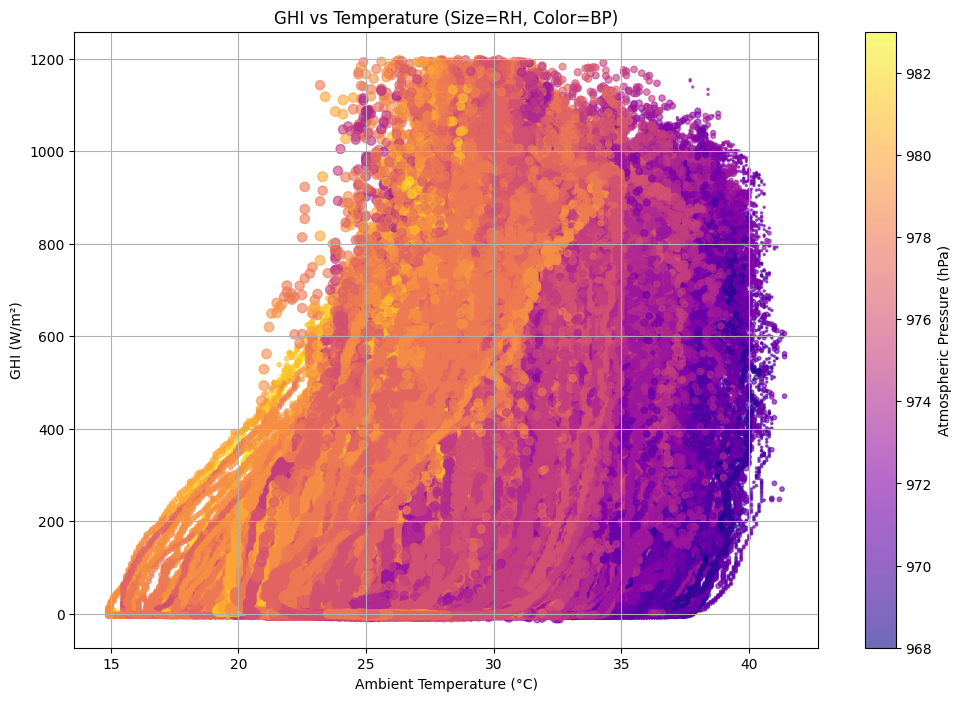

In [25]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    x=df['Tamb'],
    y=df['GHI'],
    s=df['RH']/2,  # Bubble size by RH
    c=df['BP'],     # Color by pressure
    alpha=0.6,
    cmap='plasma'
)
plt.colorbar(scatter, label='Atmospheric Pressure (hPa)')
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('GHI (W/m²)')
plt.title('GHI vs Temperature (Size=RH, Color=BP)')
plt.grid()
plt.show()